**Image Captioning using CNN and LSTM - Flickr8k**

In [43]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.This task lies at the intersection of computer vision and natural language processing.


**CNN and LSTM**

To perform Image Captioning we will require two deep learning models combined into one for the training purpose

CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction

LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word

In [44]:
image_path = '../content/drive/MyDrive/Images/Images/'

In [51]:
data = pd.read_csv("captions.csv")
data = data.head(100)
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [52]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)[:100]
    img = img/255.


    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../content/drive/MyDrive/Images/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

**Visualization**

Images and their corresponding captions

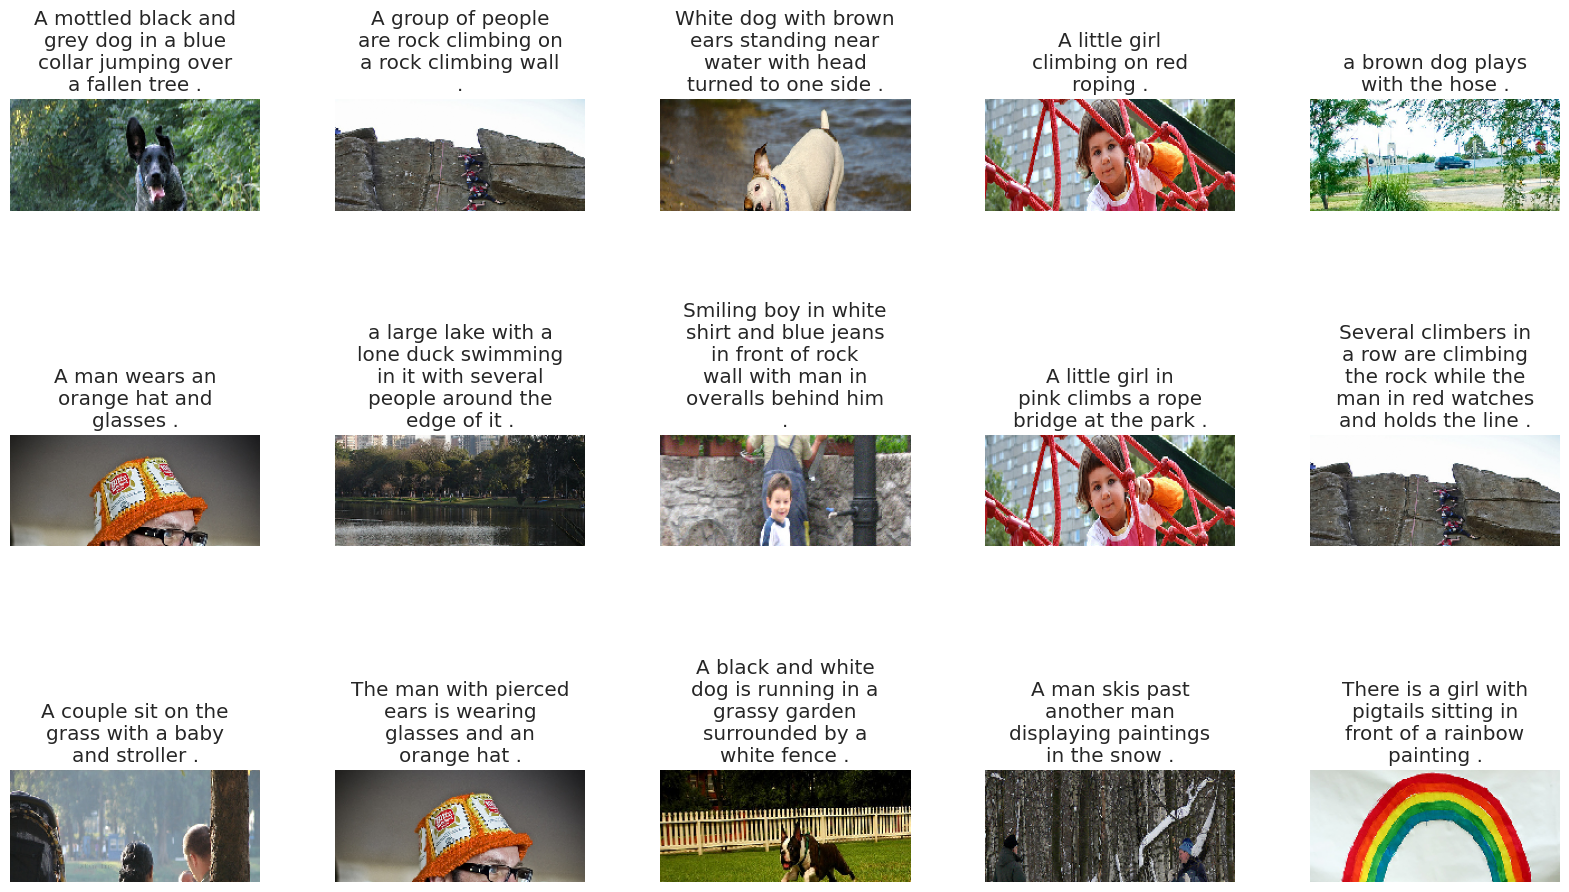

In [53]:
display_images(data.sample(15))

In [54]:
def text_preprocessing(data):
    data['caption'] = data['caption'].fillna('')
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [55]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)
print(nimages)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

20


[1, 17, 95, 70, 46, 152, 2]

In [58]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


In [59]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [60]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [61]:
from tensorflow.keras.utils import plot_model

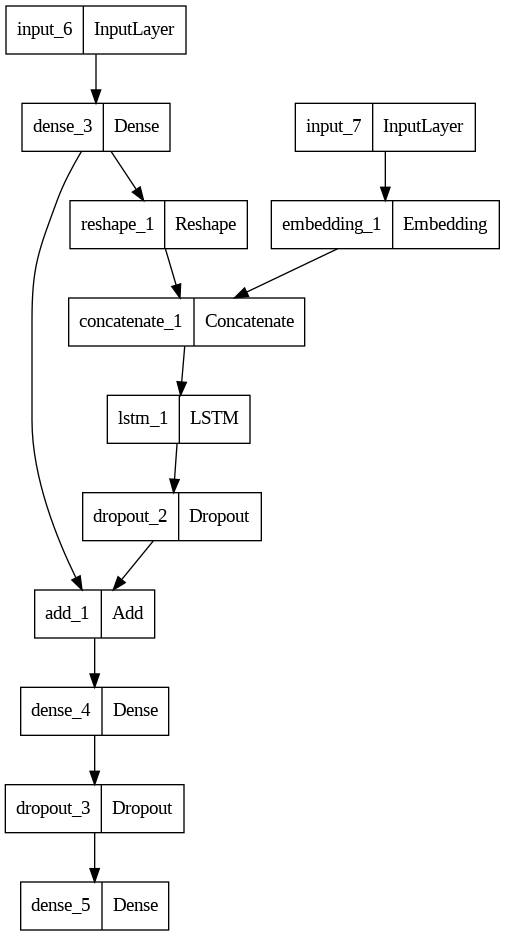

In [62]:
plot_model(caption_model)

In [63]:
caption_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 256)                  491776    ['input_6[0][0]']             
                                                                                                  
 input_7 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 256)               0         ['dense_3[0][0]']             
                                                                                            

In [64]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [65]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [66]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 5.8557

1/1 [==============================] - 9s 9s/step - loss: 5.8557 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 5.5695

1/1 [==============================] - 4s 4s/step - loss: 5.5695 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 5.4808

1/1 [==============================] - 4s 4s/step - loss: 5.4808 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 5.3970

1/1 [==============================] - 5s 5s/step - loss: 5.3970 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 5.3579

1/1 [==============================] - 4s 4s/step - loss: 5.3579 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 5.2940

1/1 [==============================] - 4s 4s/step - loss: 5.2940 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 5.1956

1/1 [==============================] - 4s 4s/step - loss: 5.1956 - lr: 0.0010
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 5.1642

1/1 [==============================] - 4s 4s/step - loss: 5.1642 - lr: 0.0010
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 5.0555

1/1 [==============================] - 5s 5s/step - loss: 5.0555 - lr: 0.0010
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 5.0250

1/1 [==============================] - 4s 4s/step - loss: 5.0250 - lr: 0.0010
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 4.9163

1/1 [==============================] - 4s 4s/step - loss: 4.9163 - lr: 0.0010
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 4.8623

1/1 [==============================] - 4s 4s/step - loss: 4.8623 - lr: 0.0010
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 4.8170

1/1 [==============================] - 4s 4s/step - loss: 4.8170 - lr: 0.0010
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 4.7535

1/1 [==============================] - 4s 4s/step - loss: 4.7535 - lr: 0.0010
Epoch 15/50
1/1 [==============================] - ETA: 0s - loss: 4.6996

1/1 [==============================] - 5s 5s/step - loss: 4.6996 - lr: 0.0010
Epoch 16/50
1/1 [==============================] - ETA: 0s - loss: 4.6512

1/1 [==============================] - 4s 4s/step - loss: 4.6512 - lr: 0.0010
Epoch 17/50
1/1 [==============================] - ETA: 0s - loss: 4.6238

1/1 [==============================] - 4s 4s/step - loss: 4.6238 - lr: 0.0010
Epoch 18/50
1/1 [==============================] - ETA: 0s - loss: 4.5459

1/1 [==============================] - 5s 5s/step - loss: 4.5459 - lr: 0.0010
Epoch 19/50
1/1 [==============================] - ETA: 0s - loss: 4.4585

1/1 [==============================] - 4s 4s/step - loss: 4.4585 - lr: 0.0010
Epoch 20/50
1/1 [==============================] - ETA: 0s - loss: 4.4620

1/1 [==============================] - 4s 4s/step - loss: 4.4620 - lr: 0.0010
Epoch 21/50
1/1 [==============================] - ETA: 0s - loss: 4.3405

1/1 [==============================] - 5s 5s/step - loss: 4.3405 - lr: 0.0010
Epoch 22/50
1/1 [==============================] - ETA: 0s - loss: 4.3917

1/1 [==============================] - 4s 4s/step - loss: 4.3917 - lr: 0.0010
Epoch 23/50
1/1 [==============================] - ETA: 0s - loss: 4.2876

1/1 [==============================] - 4s 4s/step - loss: 4.2876 - lr: 0.0010
Epoch 24/50
1/1 [==============================] - ETA: 0s - loss: 4.3082

1/1 [==============================] - 4s 4s/step - loss: 4.3082 - lr: 0.0010
Epoch 25/50
1/1 [==============================] - ETA: 0s - loss: 4.2549

1/1 [==============================] - 4s 4s/step - loss: 4.2549 - lr: 0.0010
Epoch 26/50
1/1 [==============================] - ETA: 0s - loss: 4.2489

1/1 [==============================] - 4s 4s/step - loss: 4.2489 - lr: 0.0010
Epoch 27/50
1/1 [==============================] - ETA: 0s - loss: 4.2100

1/1 [==============================] - 4s 4s/step - loss: 4.2100 - lr: 0.0010
Epoch 28/50
1/1 [==============================] - ETA: 0s - loss: 4.2608

1/1 [==============================] - 4s 4s/step - loss: 4.2608 - lr: 0.0010
Epoch 29/50
1/1 [==============================] - ETA: 0s - loss: 4.1906

1/1 [==============================] - 5s 5s/step - loss: 4.1906 - lr: 0.0010
Epoch 30/50
1/1 [==============================] - ETA: 0s - loss: 4.1449

1/1 [==============================] - 4s 4s/step - loss: 4.1449 - lr: 0.0010
Epoch 31/50
1/1 [==============================] - ETA: 0s - loss: 4.0622

1/1 [==============================] - 4s 4s/step - loss: 4.0622 - lr: 0.0010
Epoch 32/50
1/1 [==============================] - ETA: 0s - loss: 4.0593

1/1 [==============================] - 5s 5s/step - loss: 4.0593 - lr: 0.0010
Epoch 33/50
1/1 [==============================] - ETA: 0s - loss: 4.0345

1/1 [==============================] - 4s 4s/step - loss: 4.0345 - lr: 0.0010
Epoch 34/50
1/1 [==============================] - ETA: 0s - loss: 4.0012

1/1 [==============================] - 4s 4s/step - loss: 4.0012 - lr: 0.0010
Epoch 35/50
1/1 [==============================] - ETA: 0s - loss: 3.9580

1/1 [==============================] - 5s 5s/step - loss: 3.9580 - lr: 0.0010
Epoch 36/50
1/1 [==============================] - ETA: 0s - loss: 3.9504

1/1 [==============================] - 6s 6s/step - loss: 3.9504 - lr: 0.0010
Epoch 37/50
1/1 [==============================] - ETA: 0s - loss: 3.9858

1/1 [==============================] - 4s 4s/step - loss: 3.9858 - lr: 0.0010
Epoch 38/50
1/1 [==============================] - ETA: 0s - loss: 3.9672

1/1 [==============================] - 6s 6s/step - loss: 3.9672 - lr: 0.0010
Epoch 39/50
1/1 [==============================] - ETA: 0s - loss: 3.9033

1/1 [==============================] - 4s 4s/step - loss: 3.9033 - lr: 0.0010
Epoch 40/50
1/1 [==============================] - ETA: 0s - loss: 3.8238

1/1 [==============================] - 4s 4s/step - loss: 3.8238 - lr: 0.0010
Epoch 41/50
1/1 [==============================] - ETA: 0s - loss: 3.8241

1/1 [==============================] - 5s 5s/step - loss: 3.8241 - lr: 0.0010
Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: 3.7378

1/1 [==============================] - 4s 4s/step - loss: 3.7378 - lr: 0.0010
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: 3.7814

1/1 [==============================] - 5s 5s/step - loss: 3.7814 - lr: 0.0010
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 3.7466

1/1 [==============================] - 4s 4s/step - loss: 3.7466 - lr: 0.0010
Epoch 45/50
1/1 [==============================] - ETA: 0s - loss: 3.6823

1/1 [==============================] - 4s 4s/step - loss: 3.6823 - lr: 0.0010
Epoch 46/50
1/1 [==============================] - ETA: 0s - loss: 3.6030

1/1 [==============================] - 4s 4s/step - loss: 3.6030 - lr: 0.0010
Epoch 47/50
1/1 [==============================] - ETA: 0s - loss: 3.7063

1/1 [==============================] - 4s 4s/step - loss: 3.7063 - lr: 0.0010
Epoch 48/50
1/1 [==============================] - ETA: 0s - loss: 3.5967

1/1 [==============================] - 4s 4s/step - loss: 3.5967 - lr: 0.0010
Epoch 49/50
1/1 [==============================] - ETA: 0s - loss: 3.5751

1/1 [==============================] - 5s 5s/step - loss: 3.5751 - lr: 0.0010
Epoch 50/50
1/1 [==============================] - ETA: 0s - loss: 3.5938

1/1 [==============================] - 4s 4s/step - loss: 3.5938 - lr: 0.0010


In [67]:
history.history.keys()

dict_keys(['loss', 'lr'])

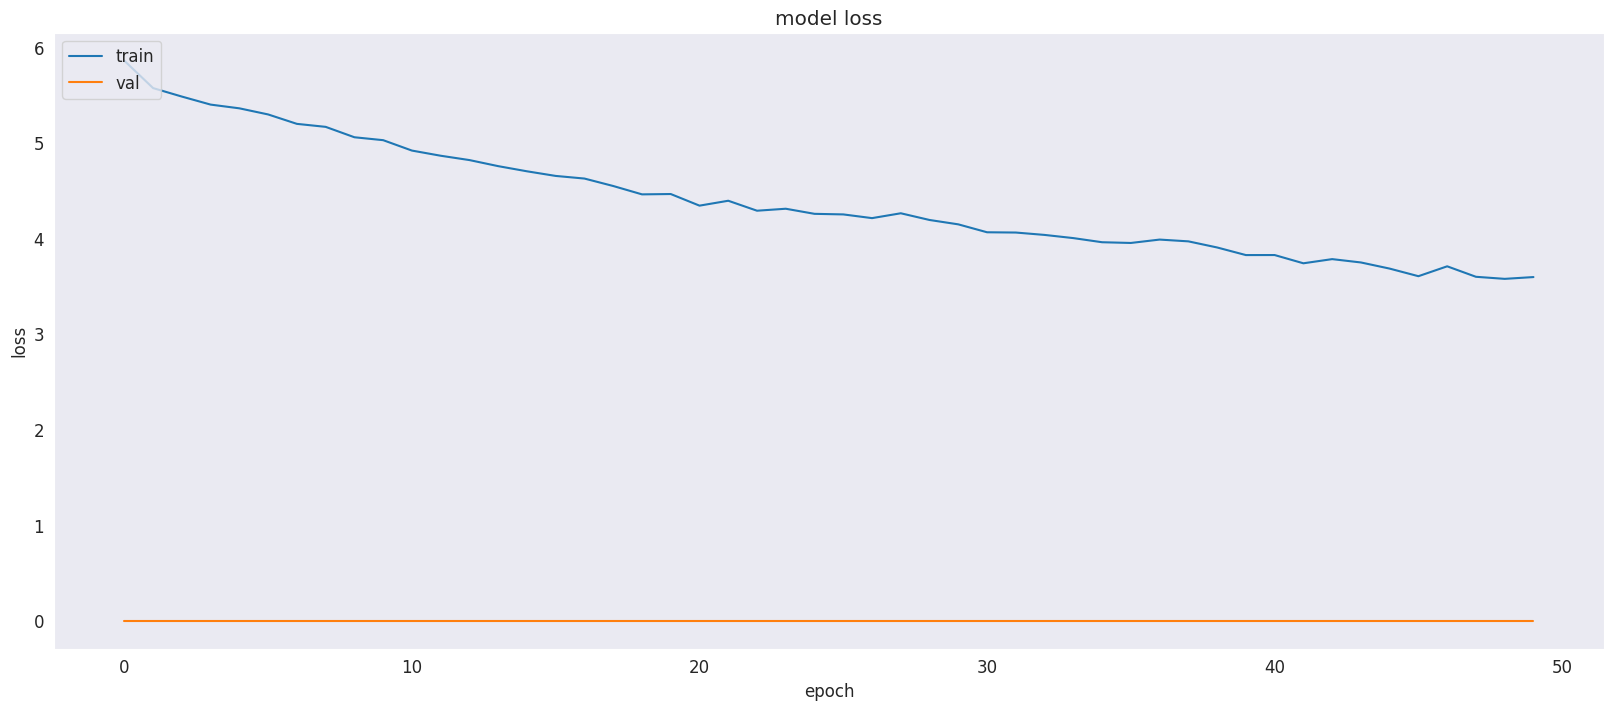

In [68]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['lr'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [70]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [71]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

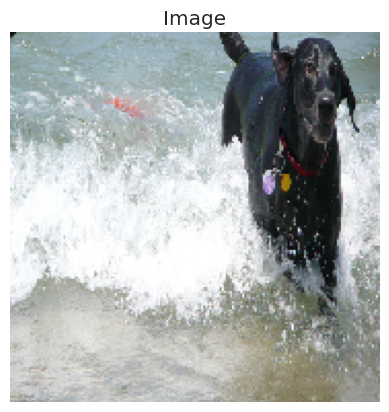

1/1 [==============================] - 0s 21ms/step
Caption: startseq dog dog with with endseq


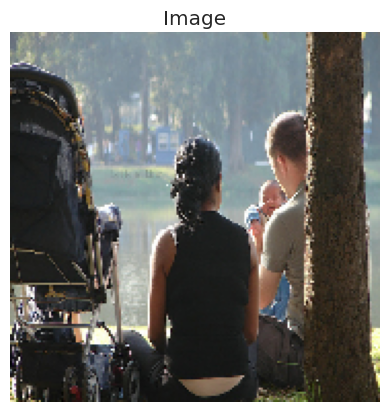

1/1 [==============================] - 0s 26ms/step
Caption: startseq man man in endseq


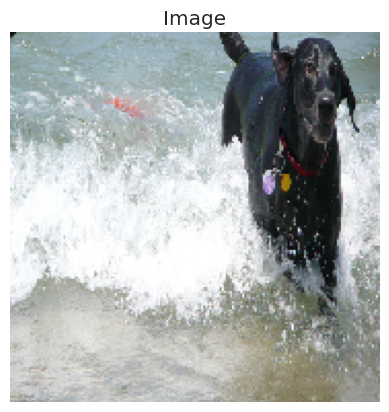

1/1 [==============================] - 0s 23ms/step
Caption: startseq dog dog with with endseq


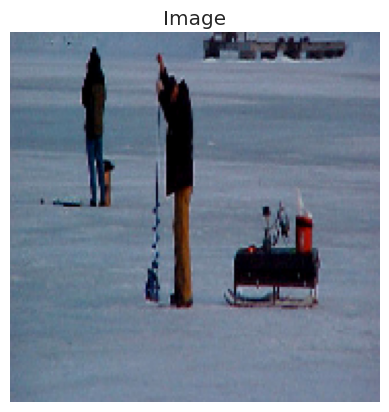

1/1 [==============================] - 0s 39ms/step
Caption: startseq man man in in in in endseq


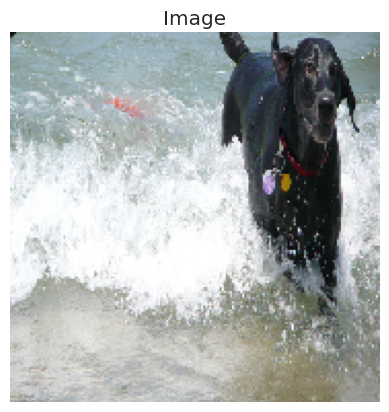

1/1 [==============================] - 0s 40ms/step
Caption: startseq dog dog with with endseq


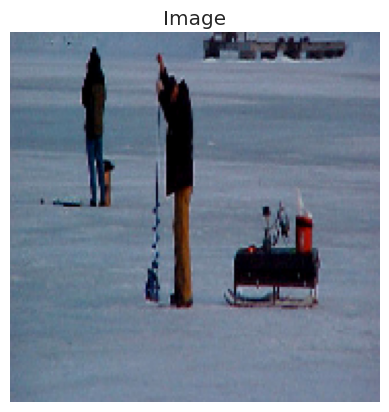

1/1 [==============================] - 0s 58ms/step
Caption: startseq man man in in in in endseq


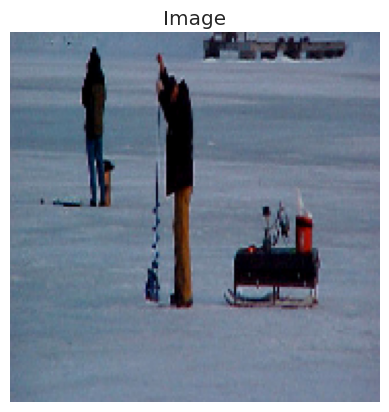

1/1 [==============================] - 0s 51ms/step
Caption: startseq man man in in in in endseq


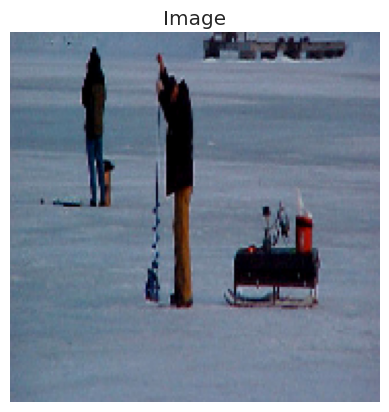

1/1 [==============================] - 0s 27ms/step
Caption: startseq man man in in in in endseq


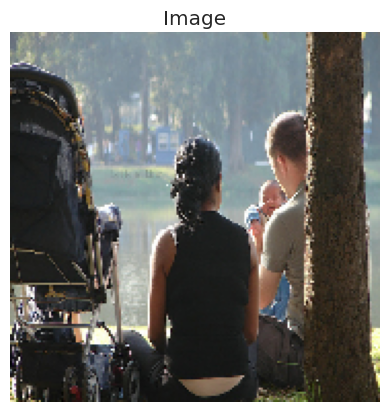

1/1 [==============================] - 0s 38ms/step
Caption: startseq man man in endseq


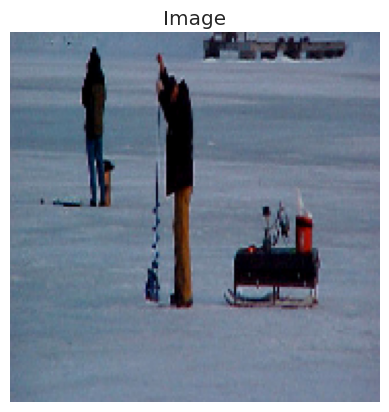

1/1 [==============================] - 0s 28ms/step
Caption: startseq man man in in in in endseq


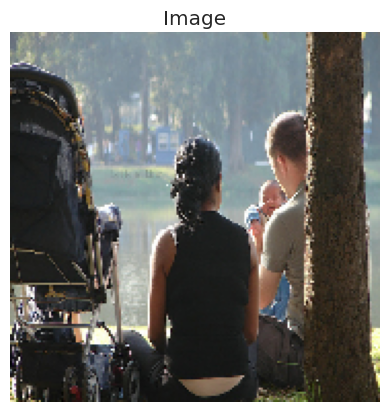

1/1 [==============================] - 0s 29ms/step
Caption: startseq man man in endseq


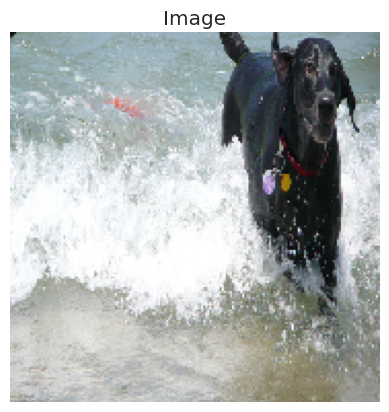

1/1 [==============================] - 0s 31ms/step
Caption: startseq dog dog with with endseq


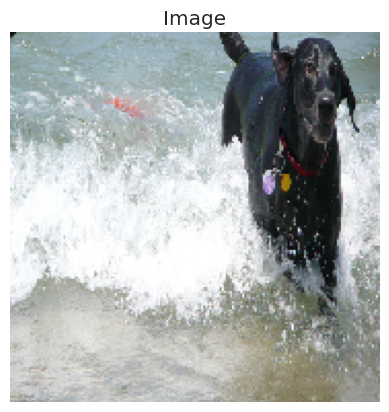

1/1 [==============================] - 0s 37ms/step
Caption: startseq dog dog with with endseq


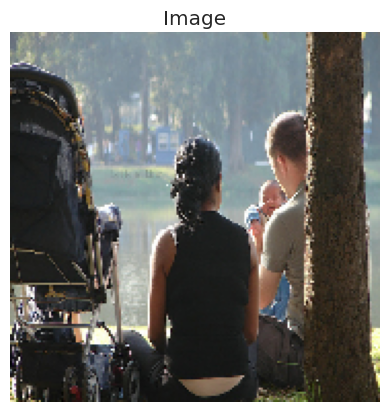

1/1 [==============================] - 0s 38ms/step
Caption: startseq man man in endseq


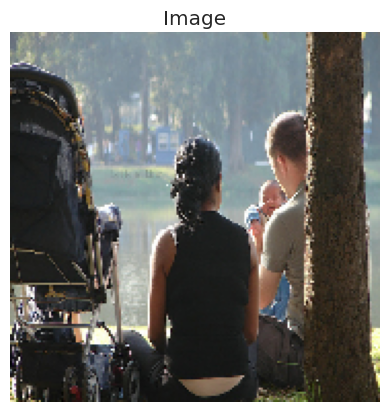

1/1 [==============================] - 0s 34ms/step
Caption: startseq man man in endseq


In [79]:
for index, record in samples.iterrows():
    img_path = os.path.join(image_path, record['image'])
    img = load_img(img_path, target_size=(180, 180))
    img = img_to_array(img)
    img = img / 255.

    # Display the image
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    plt.show()

    # Generate and display the caption
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    print("Caption:", caption)

    # Store the caption in the dataframe
    samples.loc[index, 'caption'] = caption

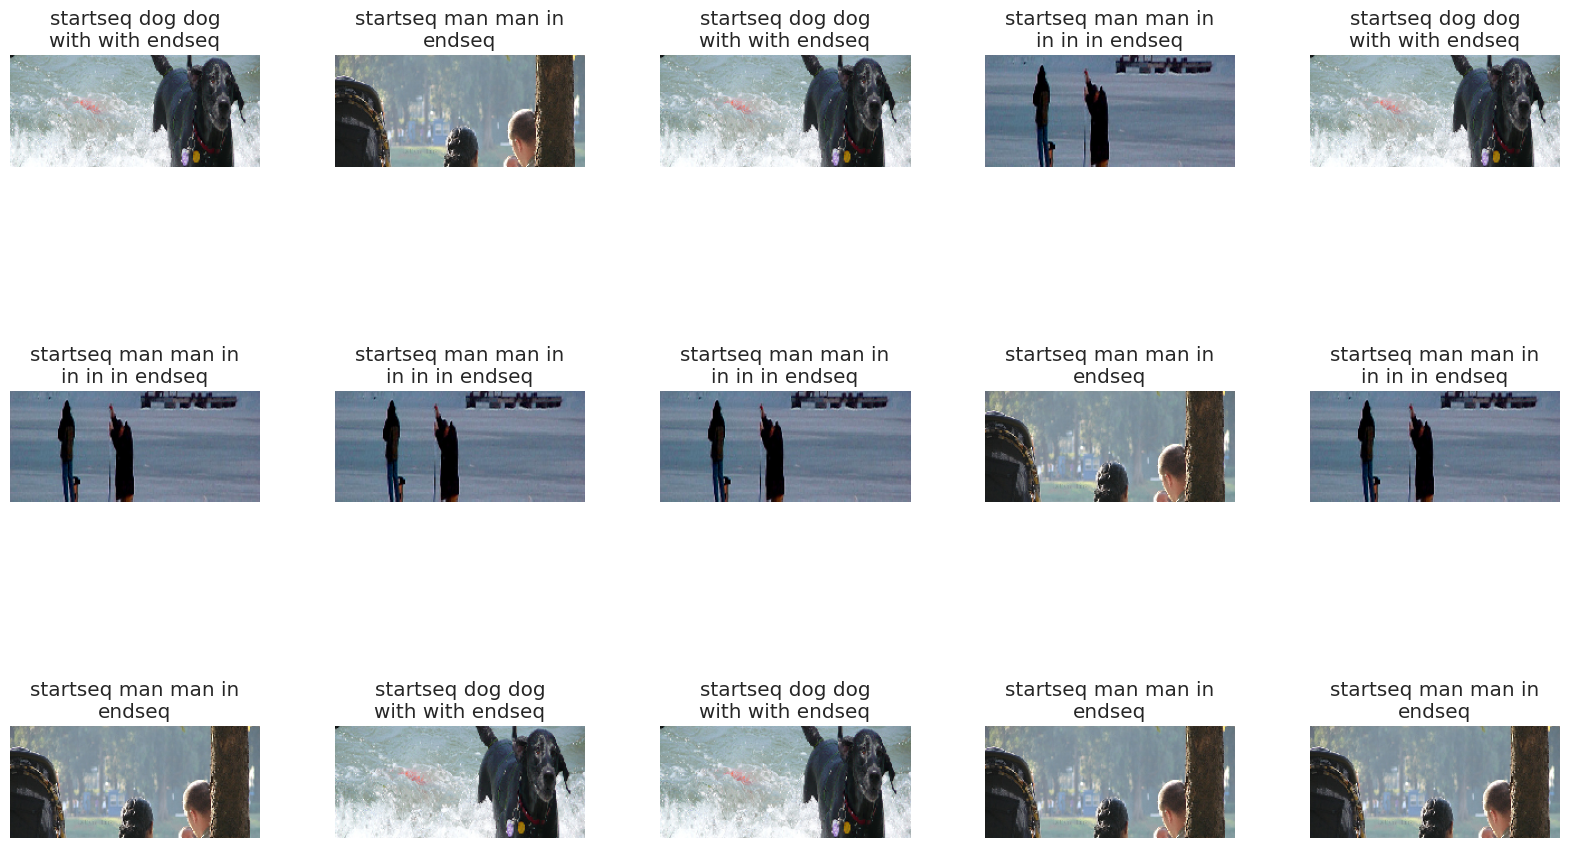

In [80]:
display_images(temp_df=samples)